<a href="https://colab.research.google.com/github/Rakshit-Sawarn-iitb/WIDS-Brain-Tumor-Detection/blob/main/BrainTumorDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
from glob import glob

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
class BrainMRIDataset(Dataset):

  def __init__(self,data_dir,reshape=True,height=128,width=128,autoencoder =False):

    self.dataDirectory = data_dir
    self.no_class = glob(data_dir+'/no/*')
    self.yes_class = glob(data_dir+'/yes/*')

    self.height = height
    self.width = width
    self.reshape = reshape
    self.autoencoder = autoencoder

    labels = [0 for i in range(len(self.no_class))]
    labels += [1 for i in range(len(self.yes_class))]

    image_links = self.no_class + self.yes_class

    self.dataframe = pd.DataFrame({"image":image_links, "labels":labels})
    self.dataframe.reset_index(inplace = True ,drop=True)

  def __len__(self):
    return len(self.no_class)+len(self.yes_class)

  def __getitem__(self,idx):

    image_list = self.dataframe["image"][idx]
    label_list = self.dataframe["labels"][idx]

    if type(image_list) == str:
      image_list = [image_list]

    if not isinstance(label_list,np.int64):
      label_list = label_list.values

    image_array = []

    for image in image_list:
      image = Image.open(image).convert("L")

      if self.reshape:
        image = image.resize((self.height,self.width))

      array = np.asarray(image)

      array = array.reshape(1,self.height,self.width)

      image_array.append(array)



    return [torch.tensor(image_array,device=device),torch.tensor(label_list,device=device)]



  def __repr__(self):
    return str(self.dataframe.head(10))

In [61]:
class BrainTumorDetection(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Sequential(
      nn.Conv2d(1,256,kernel_size=3), #126*126*256
      nn.MaxPool2d(2,2), # 63*63*256

      nn.Conv2d(256,32,kernel_size=2) #63-2+1 = 62*62*32
    )

    # n-f+2p/s +1

    self.linear1 = nn.Linear(62,128)
    self.linear2 = nn.Linear(128,64)
    self.flat = nn.Flatten(1)
    self.linear3 = nn.Linear(126976,2)


  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.linear1(x))
    x = self.linear2(x)
    x = self.flat(x)
    x = self.linear3(x)

    return x

In [54]:
dataset = BrainMRIDataset("/content/drive/MyDrive/brain_tumor_dataset")
print(dataset)

                                               image  labels
0  /content/drive/MyDrive/brain_tumor_dataset/no/...       0
1  /content/drive/MyDrive/brain_tumor_dataset/no/...       0
2  /content/drive/MyDrive/brain_tumor_dataset/no/...       0
3  /content/drive/MyDrive/brain_tumor_dataset/no/...       0
4  /content/drive/MyDrive/brain_tumor_dataset/no/...       0
5  /content/drive/MyDrive/brain_tumor_dataset/no/...       0
6  /content/drive/MyDrive/brain_tumor_dataset/no/...       0
7  /content/drive/MyDrive/brain_tumor_dataset/no/...       0
8  /content/drive/MyDrive/brain_tumor_dataset/no/...       0
9  /content/drive/MyDrive/brain_tumor_dataset/no/...       0


In [62]:
model = BrainTumorDetection().to(device)

In [56]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [57]:
num_epochs = 10
batch_size = 32
learning_rate = 0.001
loss_list = []

In [58]:
classes = ('Tumor Detected', 'No Tumor Detected')

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [63]:
for epoch in range(num_epochs):
  total_loss = 0.0

  for n in range(len(dataset)//batch_size):

    data , target = dataset[n*batch_size : (n+1)*batch_size]

    ypred = model.forward(data.float())
    loss = loss_fn(ypred,target)

    total_loss+=loss

    optimizer.zero_grad() #clear the gradients
    loss.backward() # calculate the gradeint
    optimizer.step() # Wn = Wo - lr* gradeint

  loss_list.append(total_loss/batch_size)

  print("Epochs {}  Training Loss {:.2f}".format(epoch+1,total_loss/n))

Epochs 1  Training Loss 1.65
Epochs 2  Training Loss 1.65
Epochs 3  Training Loss 1.65
Epochs 4  Training Loss 1.65
Epochs 5  Training Loss 1.65
Epochs 6  Training Loss 1.65
Epochs 7  Training Loss 1.65
Epochs 8  Training Loss 1.65
Epochs 9  Training Loss 1.65
Epochs 10  Training Loss 1.65


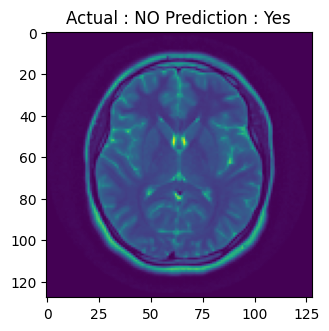

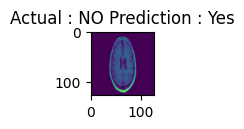

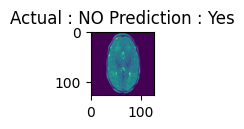

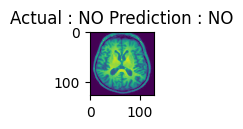

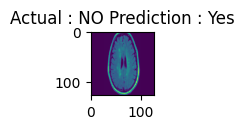

In [64]:
mapping = {0:"NO",1:"Yes"}
fig = plt.figure(figsize=(20,20))

for i in range(5):
  data,target = dataset[i]
  pred = model.forward(data.float())

  pred = torch.argmax(pred,dim=1)
  plt.subplot(5,5,i+1)
  plt.imshow(data[0][0].cpu())
  plt.title(f"Actual : {mapping[target.cpu().detach().item()]} Prediction : {mapping[pred.cpu().detach().item()]}")
  plt.show()